## Structure of the Data
* Artists -> Songs -> Attributes
    * Artists
        * Nominal Attributes:
            * artist: name
            * artist_id: spotify_id
            * one-to-one relationships
        * Popularity-Related Attributes:
            * followers: Amount of Spotify listeners following artist's page
            * popularity: Aggregate Popularity of All Artist's Songs
            * one-to-one relationships
        * Categorical Attributes:
            * genre: list of subgenres that Spotify has classified Song As.
            * one-to-many relationship
    * Songs
        * Nominal Attributes:
            * Song
            * Performer
            * id
            * id_y
            * id_fk
            * release_date
            * one-to-one relationships
        * Interval Attributes:
            * 0 to 1 Intervals:
                * danceability:
                * energy:
                * liveness:
                * speechiness:
                * acousticness
                * instrumentalness:
                * valence:
            * Area-Specific Intervals:
                * tempo
                * duration
                * popularity
                * loudness
        * Categorical Attributes:
            * explicit
            * timesignature
            * key
            * mode
            * genre
            * genre_super
            * chart
    * Billboard
        * Nominal Attributes:
            * Song
            * Performer
            * SongID
            * WeekID
        * Ordinal Attributes:
            * Week Position
            * bill_popularity
        * Derivates Based on Week Position:
            * Previous Week Position (Week Position @ t-1)
            * Peak Position (Max Inclusive of Song's Current Week Position)
            * Weeks on Chart (Cumlative Sum of All Weeks on Chart)
            * Instance (Amount of Times Song Entered the Chart)

In [7]:
# Stories to Tell with Billboard Data Based on Time.
    # How Long Does a Song Last on the Billboard Chart? What is the Average Longevity of A Popular Song?
    # What Was the Biggest Jump Between Weeks? Previous Week Position - Week Position
    # What Was the Longest Gap Between a Song's Release and its Charting? Is This Occuring More or Less Frequently With the Advent of Streaming?
    # Which Song Lasted the Longest on the Chart? Instance staying the same.
    # Was There a Meaningful Difference in Attributes Between 1 Songs vs. the other 99 Field?
    # Which Song Was the Most Average, given the averages on the billboard songs' attributes for the year?
    # Which Song Deviated the Most From These Attributes? 
    # How many Songs Enter and Leave the chart in a given week, month, year?
    # How has the genre make-up of the Hot 100 changed over time? Is Pop more popular in the Spring? Does Billboard Valence Decrease in the Winter?
    # Questions that Ground Our Artists, Songs and their Spotify Attributes in Time and Explain the Changes That Have Occured In Popular Music.   

In [8]:
import pandas as pd, sqlalchemy as sql, numpy as np, datetime as dt, os, re, time
import operator, requests, string as s, random
import plotly.graph_objects as go
import plotly.express as px

In [9]:
engine = sql.create_engine("sqlite:///../src/data/music.db")
with engine.connect() as con:
    billboard = pd.read_sql("SELECT * FROM billboard", con=con)
    attributes = pd.read_sql("SELECT * FROM attributes", con=con)
    artists = pd.read_sql("SELECT * FROM artists", con=con)
    recommend_join = pd.read_sql("SELECT * FROM recommendation_join", con=con)
    artists_join = pd.read_sql("SELECT * FROM artists_join", con=con)

In [10]:
billboard.shape

(109600, 10)

In [11]:
billboard.WeekID = pd.to_datetime(billboard.WeekID)

In [12]:
attributes.release_date = pd.to_datetime(attributes.release_date)

In [13]:
sample_year = billboard[lambda x: x.WeekID < dt.datetime(2000, 1, 1)]

In [14]:
samples_for_year = attributes[lambda x: ((x.release_date < dt.datetime(2000, 1, 1)) & (x.release_date > dt.datetime(1998, 12, 31)) & (x.chart == 0))]

In [15]:
# Summary of Year Via Interval Attributes

In [16]:
df_99 =  sample_year.merge(attributes.loc[:, ["SongID", "energy", "popularity"]], "left", on=["SongID"])

In [17]:
df_99 = df_99.drop_duplicates(subset=["SongID", "Instance"])

In [35]:
most_recent = billboard[lambda x: x.WeekID > dt.datetime(2018, 12, 31)].merge(attributes, "left", on=["SongID"])

In [18]:
fig = px.histogram(df_99, x="energy")
fig.show()

In [19]:
fig = px.histogram(samples_for_year, x="energy")
fig.show()

In [20]:
fig = px.box(df_99, x="energy")
fig.show()

In [21]:
fig = px.box(samples_for_year, x="energy")
fig.show()

In [22]:
fig = px.violin(df_99, x="energy", box=True, points="all")
fig.show()

In [23]:
fig = px.violin(samples_for_year, x="energy", box=True, points="all")
fig.show()

In [24]:
fig = px.scatter(df_99, x='energy', y='bill_popularity', marginal_x='histogram', marginal_y='rug')
fig.show()

In [25]:
fig = px.scatter(df_99, x='energy', y='popularity', marginal_x='histogram', marginal_y='violin')
fig.show()

In [26]:
fig = px.scatter(samples_for_year, x='energy', y='popularity', marginal_x='histogram', marginal_y='violin')
fig.show()

In [27]:
fig = px.scatter(df_99, x='energy', y='bill_popularity', marginal_x='histogram', marginal_y='violin')
fig.show()

In [28]:
df_99_full =  sample_year.merge(attributes, "left", on=["SongID"])

In [29]:
df_interval_attr = df_99_full.loc[:, ["SongID", "danceability", "energy", "liveness", "acousticness", "instrumentalness", "loudness", "explicit", "tempo", "duration","valence", "popularity", "bill_popularity"]].drop_duplicates(subset=["SongID"])

In [30]:
fig = px.imshow(df_interval_attr.corr())
fig.show()

In [31]:
fig = px.imshow(samples_for_year.loc[:, ["SongID", "danceability", "energy", "liveness", "acousticness", "instrumentalness", "loudness", "explicit", "tempo", "duration","valence", "popularity",]].corr())
fig.show()

In [32]:
fig = px.bar(df_99_full.drop_duplicates("SongID").groupby("genre_super", as_index=False).count().sort_values("SongID", ascending=False), x="genre_super", y="SongID", title="# of Unique Songs")
fig.show()

In [33]:
pie_df = df_99_full.assign(genre_super = lambda x: x.genre_super.apply(lambda g: "other" if g == "missing" or g == "empty" else g)).groupby("genre_super", as_index=False).sum()
fig = px.pie(pie_df, values="Week Position", names="genre_super", title="1999 Genre % by Positions")
fig.show()

In [36]:
pie_df = most_recent.assign(genre_super = lambda x: x.genre_super.apply(lambda g: "other" if g == "missing" or g == "empty" else g)).groupby("genre_super", as_index=False).sum()
fig = px.pie(pie_df, values="Week Position", names="genre_super", title="2019 Genre % by Positions")
fig.show()

In [37]:
fig = px.bar(df_99_full.drop_duplicates("SongID").groupby("Instance", as_index=False).count().sort_values("SongID", ascending=False), x="Instance", y="SongID", title="Instance Type")
fig.show()

In [38]:
fig = px.bar(df_99_full.drop_duplicates("SongID").groupby("key", as_index=False).count().sort_values("SongID", ascending=False), x="key", y="SongID", title="Key Type")
fig.show()

In [39]:
fig = px.bar(df_99_full.drop_duplicates("SongID").groupby("mode", as_index=False).count().sort_values("SongID", ascending=False), x="mode", y="SongID", title="Major/Minor")
fig.show()

In [40]:
fig = px.bar(df_99_full.drop_duplicates("SongID").groupby("timesignature", as_index=False).count().sort_values("SongID", ascending=False), x="timesignature", y="SongID", title="Time Signatures")
fig.show()

In [41]:
pie_df = df_99_full.drop_duplicates("SongID")
pie_df = pie_df.assign(explicit_name = lambda x: x.explicit.apply(lambda x: 1))
fig = px.pie(pie_df.dropna(), values="explicit_name", names="explicit", title= "% of Songs Explicit 1999")
fig.show()

In [42]:
pie_df = most_recent.drop_duplicates("SongID")
pie_df = most_recent.assign(explicit_name = lambda x: x.explicit.apply(lambda x: 1))
fig = px.pie(pie_df.dropna(), values="explicit_name", names="explicit", title= "% of Songs Explicit 2019")
fig.show()

In [43]:
most_recent[lambda x: x["Week Position"] == 1].SongID.unique().shape

(16,)

In [44]:
most_recent[lambda x: x["Week Position"] <= 10].SongID.unique().shape

(62,)

In [45]:
most_recent.SongID.unique().shape

(633,)

In [46]:
df_99_full[lambda x: x["Week Position"] == 1].SongID.unique().shape

(15,)

In [47]:
df_99_full[lambda x: x["Week Position"] == 1]["Weeks on Chart"].mean()

10.75

In [48]:
df_99_full[lambda x: x["Week Position"] <= 10].SongID.unique().shape

(77,)

In [49]:
df_99_full[lambda x: x["Week Position"] <= 10]["Weeks on Chart"].mean()

11.76923076923077

In [50]:
df_99_full.SongID.unique().shape

(417,)

In [51]:
df_99_full["Weeks on Chart"].mean()

10.200192307692308

In [52]:
# Shows amount of time a Song Was On the Chart Before It Fell Off
df_99_full.drop_duplicates(subset=["SongID"], keep="last")["Weeks on Chart"].mean()

14.33093525179856

In [53]:
most_recent.drop_duplicates(subset=["SongID"], keep="last")["Weeks on Chart"].mean()

10.090047393364928

In [54]:
# Songs that Debuted at the Top of the Chart
most_recent[lambda x:( x["Week Position"] == 1) & (x["Weeks on Chart"] < 2)]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
400,2019-02-02,1,7 rings,ariana grande,0.0,1.0,1.0,7 ringsariana grande,100,1.0,...,4.0,178626.0,6ocbgoVGwYJhOv1GgI9NsF,1.0,85.0,2019-02-08,1.0,6ocbgoVGwYJhOv1GgI9NsF,"['dance pop', 'pop']",pop
1000,2019-03-16,1,sucker,jonas brothers,0.0,1.0,1.0,suckerjonas brothers,100,1.0,...,4.0,181026.0,22vgEDb5hykfaTwLuskFGD,0.0,81.0,2019-06-07,1.0,22vgEDb5hykfaTwLuskFGD,"['boy band', 'dance pop', 'pop', 'post-teen pop']",pop
4100,2019-10-19,1,highest in the room,travis scott,0.0,1.0,1.0,highest in the roomtravis scott,100,1.0,...,4.0,175720.0,3eekarcy7kvN4yt5ZFzltW,1.0,84.0,2019-10-04,1.0,3eekarcy7kvN4yt5ZFzltW,"['rap', 'slap house']",rap


In [55]:
# Song of Year that Had the Longest Run 
df_99_full[lambda x: x["Weeks on Chart"] == x["Weeks on Chart"].max()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
649,1999-02-13,50,too close,next,48.0,1.0,53.0,too closenext,51,1.0,...,4.0,259440.0,5IFCyWplye09HytIP80RCF,1.0,67.0,1997-09-30,1.0,5IFCyWplye09HytIP80RCF,"['boy band', 'hip hop', 'hip pop', 'minneapoli...",r&b


In [56]:
# Song of Year that Had the Longest Run
most_recent[lambda x: x["Weeks on Chart"] == x["Weeks on Chart"].max()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
4320,2019-11-02,21,sunflower (spider-man: into the spider-verse),post malone & swae lee,19.0,1.0,53.0,sunflower (spider-man: into the spider-verse)p...,80,1.0,...,4.0,158040.0,3KkXRkHbMCARz0aVfEt68P,0.0,83.0,2018-12-14,1.0,3KkXRkHbMCARz0aVfEt68P,"['dfw rap', 'melodic rap', 'rap']",rap


In [57]:
# Song that Had the Farthest Drop 
df_99_full.drop_duplicates(subset=["SongID"], keep="last")[lambda x: x["Week Position"] == x["Week Position"].min()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
5100,1999-12-25,1,smooth,santana featuring rob thomas,1.0,1.0,22.0,smoothsantana featuring rob thomas,100,1.0,...,4.0,294986.0,0n2SEXB2qoRQg171q7XqeW,0.0,69.0,1999-06-15,1.0,0n2SEXB2qoRQg171q7XqeW,"['blues rock', 'classic rock', 'mexican classi...",rock


In [58]:
# Song that Had the Farthest Drop (will work better when billboard data is full)
most_recent.drop_duplicates(subset=["SongID"], keep="last")[lambda x: x["Week Position"] == x["Week Position"].min()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
5100,2019-12-28,1,all i want for christmas is you,mariah carey,1.0,1.0,35.0,all i want for christmas is youmariah carey,100,9.0,...,4.0,241106.0,0bYg9bo50gSsH3LtXe2SQn,0.0,88.0,1994-11-01,1.0,0bYg9bo50gSsH3LtXe2SQn,"['dance pop', 'pop', 'urban contemporary']",pop


In [59]:
# Largest Week to Week Increase
df_99_full.assign(rising = lambda x: x["Previous Week Position"] - x["Week Position"]).sort_values("rising", ascending=False)

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,rising
1315,1999-04-03,16,when i close my eyes,shanice,91.0,16.0,2.0,when i close my eyesshanice,85,1.0,...,202226.0,3EKEsJWz8oaxG1lfrojWug,0.0,33.0,1999-02-16,1.0,3EKEsJWz8oaxG1lfrojWug,"['hip pop', 'new jack swing', 'quiet storm', '...",r&b,75.0
1424,1999-04-10,25,please remember me,tim mcgraw,94.0,25.0,2.0,please remember metim mcgraw,76,1.0,...,296333.0,4C5pVpypNmXpSN42rIqmpK,0.0,45.0,2010-11-30,1.0,4C5pVpypNmXpSN42rIqmpK,"['contemporary country', 'country', 'country r...",country,69.0
2019,1999-05-22,20,chante's got a man,chante moore,85.0,20.0,2.0,chante's got a manchante moore,81,1.0,...,264973.0,6v4UCusR4LTRlM5WHBUyxQ,0.0,39.0,1999-01-01,1.0,6v4UCusR4LTRlM5WHBUyxQ,"['hip pop', 'neo soul', 'new jack swing', 'qui...",r&b,65.0
614,1999-02-13,15,faded pictures,case & joe,73.0,15.0,8.0,faded picturescase & joe,86,1.0,...,229773.0,1CAw3ethNuSDPf3E7luSFF,0.0,61.0,1999-01-01,1.0,1CAw3ethNuSDPf3E7luSFF,"['hip hop', 'hip pop', 'neo soul', 'new jack s...",r&b,58.0
2515,1999-06-26,16,no pigeons,sporty thievz featuring mr. woods,73.0,16.0,7.0,no pigeonssporty thievz featuring mr. woods,85,1.0,...,205520.0,6r78MF6BFaeEG8rBw9Y5nQ,1.0,31.0,1999-06-15,1.0,6r78MF6BFaeEG8rBw9Y5nQ,[],rap,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,1999-03-13,99,nann,trick daddy featuring trina,0.0,99.0,1.0,nanntrick daddy featuring trina,2,1.0,...,167400.0,7d9I42jF759n5HuUeoulzR,1.0,51.0,1999-03-30,1.0,7d9I42jF759n5HuUeoulzR,"['crunk', 'dirty south rap', 'gangster rap', '...",rap,-99.0
499,1999-01-30,100,another way,tevin campbell,0.0,100.0,1.0,another waytevin campbell,1,1.0,...,295357.0,0W8YWHeFFimvyPOc0AgRBq,0.0,19.0,2001-01-01,1.0,0W8YWHeFFimvyPOc0AgRBq,"['hip pop', 'neo soul', 'new jack swing', 'qui...",r&b,-100.0
4299,1999-10-23,100,simon says,pharoahe monch,0.0,100.0,1.0,simon sayspharoahe monch,1,1.0,...,173159.0,67IvfvAMYQzJEeHopvwMMW,1.0,61.0,1999-10-19,1.0,67IvfvAMYQzJEeHopvwMMW,"['alternative hip hop', 'conscious hip hop', '...",rap,-100.0
4199,1999-10-16,100,steam,ty herndon,0.0,100.0,1.0,steamty herndon,1,1.0,...,216693.0,2sPXJCnKyQ1SWjc2JdFnQK,0.0,26.0,1999-10-20,1.0,2sPXJCnKyQ1SWjc2JdFnQK,"['country', 'country road', 'country rock']",country,-100.0


In [60]:
# Largest Week to Week Increase
most_recent.assign(rising = lambda x: x["Previous Week Position"] - x["Week Position"]).sort_values("rising", ascending=False)

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,rising
1801,2019-05-11,2,me!,taylor swift featuring brendon urie,100.0,2.0,2.0,me!taylor swift featuring brendon urie,99,1.0,...,193000.0,2Rk4JlNc2TPmZe2af99d45,0.0,77.0,2019-08-23,1.0,2Rk4JlNc2TPmZe2af99d45,['modern rock'],rock,98.0
4707,2019-11-30,8,everything i wanted,billie eilish,74.0,8.0,2.0,everything i wantedbillie eilish,93,1.0,...,245425.0,3ZCTVFBt2Brf31RLEnCkWJ,0.0,83.0,2019-11-13,1.0,3ZCTVFBt2Brf31RLEnCkWJ,"['art pop', 'electropop', 'pop']",pop,66.0
613,2019-02-16,14,bury a friend,billie eilish,74.0,14.0,2.0,bury a friendbillie eilish,87,1.0,...,193143.0,4SSnFejRGlZikf02HLewEF,0.0,77.0,2019-03-29,1.0,4SSnFejRGlZikf02HLewEF,"['art pop', 'electropop', 'pop']",pop,60.0
4115,2019-10-19,16,playing games,summer walker,75.0,16.0,6.0,playing gamessummer walker,85,2.0,...,143226.0,2xyx0o4xNOLLjBSbOOdcbA,1.0,76.0,2019-10-04,1.0,2xyx0o4xNOLLjBSbOOdcbA,"['kentucky hip hop', 'pop', 'pop rap', 'r&b', ...",rap,59.0
1430,2019-04-13,31,wish you were gay,billie eilish,84.0,31.0,5.0,wish you were gaybillie eilish,70,1.0,...,221543.0,3Fj47GNK2kUF0uaEDgXLaD,0.0,76.0,2019-03-29,1.0,3Fj47GNK2kUF0uaEDgXLaD,"['art pop', 'electropop', 'pop']",pop,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,2019-08-03,100,megatron,nicki minaj,0.0,100.0,4.0,megatronnicki minaj,1,2.0,...,190746.0,1ZDmxwg7Lywlx68b7SsJjj,1.0,66.0,2019-06-21,1.0,1ZDmxwg7Lywlx68b7SsJjj,"['dance pop', 'hip pop', 'pop', 'pop rap', 'qu...",pop,-100.0
1699,2019-04-27,100,on my way to you,cody johnson,0.0,100.0,8.0,on my way to youcody johnson,1,5.0,...,213306.0,3OjNkFFZavF89xvRqWCXmU,0.0,66.0,2019-01-18,1.0,3OjNkFFZavF89xvRqWCXmU,"['contemporary country', 'country road', 'texa...",country,-100.0
4599,2019-11-16,100,big boy diamonds,gucci mane featuring kodak black & london on d...,0.0,100.0,1.0,big boy diamondsgucci mane featuring kodak bla...,1,1.0,...,151481.0,5FDCDBFDKpf7TLzDx6r2Lp,1.0,57.0,2019-10-18,1.0,5FDCDBFDKpf7TLzDx6r2Lp,"['atl hip hop', 'dirty south rap', 'gangster r...",rap,-100.0
5099,2019-12-21,100,best on earth,russ & bia,0.0,100.0,1.0,best on earthruss & bia,1,1.0,...,160720.0,0xKBkLcF71uUQeTA7FSu4A,1.0,71.0,2020-01-31,1.0,0xKBkLcF71uUQeTA7FSu4A,"['hawaiian hip hop', 'rap']",rap,-100.0


In [61]:
# Largest Week to Week DECREASE
most_recent.assign(rising = lambda x: x["Previous Week Position"] - x["Week Position"])[lambda x: x["Previous Week Position"] > 0].sort_values("rising", ascending=True)

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,rising
4595,2019-11-16,96,on god,kanye west,23.0,23.0,2.0,on godkanye west,5,1.0,...,136350.0,2SasoXZyv82yYgHiVOvxQn,0.0,62.0,2019-10-25,1.0,2SasoXZyv82yYgHiVOvxQn,"['chicago rap', 'rap']",rap,-73.0
4591,2019-11-16,92,selah,kanye west,19.0,19.0,2.0,selahkanye west,9,1.0,...,164619.0,39JRmdKFka1Oe09FoOCPI4,0.0,62.0,2019-10-25,1.0,39JRmdKFka1Oe09FoOCPI4,"['chicago rap', 'rap']",rap,-73.0
2791,2019-07-13,92,megatron,nicki minaj,20.0,20.0,2.0,megatronnicki minaj,9,1.0,...,190746.0,1ZDmxwg7Lywlx68b7SsJjj,1.0,66.0,2019-06-21,1.0,1ZDmxwg7Lywlx68b7SsJjj,"['dance pop', 'hip pop', 'pop', 'pop rap', 'qu...",pop,-72.0
4583,2019-11-16,84,closed on sunday,kanye west,17.0,17.0,2.0,closed on sundaykanye west,17,1.0,...,151873.0,3JWiDGQX2eTlFvKj3Yssj3,0.0,64.0,2019-10-25,1.0,3JWiDGQX2eTlFvKj3Yssj3,"['chicago rap', 'rap']",rap,-67.0
2698,2019-07-06,99,omerta,drake,35.0,35.0,2.0,omertadrake,2,1.0,...,219506.0,3kCwyvhvVTyehIzYN2I0nF,1.0,58.0,2019-06-15,1.0,3kCwyvhvVTyehIzYN2I0nF,"['canadian hip hop', 'canadian pop', 'hip hop'...",rap,-64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,2019-04-13,31,wish you were gay,billie eilish,84.0,31.0,5.0,wish you were gaybillie eilish,70,1.0,...,221543.0,3Fj47GNK2kUF0uaEDgXLaD,0.0,76.0,2019-03-29,1.0,3Fj47GNK2kUF0uaEDgXLaD,"['art pop', 'electropop', 'pop']",pop,53.0
4115,2019-10-19,16,playing games,summer walker,75.0,16.0,6.0,playing gamessummer walker,85,2.0,...,143226.0,2xyx0o4xNOLLjBSbOOdcbA,1.0,76.0,2019-10-04,1.0,2xyx0o4xNOLLjBSbOOdcbA,"['kentucky hip hop', 'pop', 'pop rap', 'r&b', ...",rap,59.0
613,2019-02-16,14,bury a friend,billie eilish,74.0,14.0,2.0,bury a friendbillie eilish,87,1.0,...,193143.0,4SSnFejRGlZikf02HLewEF,0.0,77.0,2019-03-29,1.0,4SSnFejRGlZikf02HLewEF,"['art pop', 'electropop', 'pop']",pop,60.0
4707,2019-11-30,8,everything i wanted,billie eilish,74.0,8.0,2.0,everything i wantedbillie eilish,93,1.0,...,245425.0,3ZCTVFBt2Brf31RLEnCkWJ,0.0,83.0,2019-11-13,1.0,3ZCTVFBt2Brf31RLEnCkWJ,"['art pop', 'electropop', 'pop']",pop,66.0


In [62]:
# Largest Week to Week DECREASE
df_99_full.assign(rising = lambda x: x["Previous Week Position"] - x["Week Position"])[lambda x: x["Previous Week Position"] > 0].sort_values("rising", ascending=True)

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,rising
3257,1999-08-14,58,the day the world went away,nine inch nails,17.0,17.0,2.0,the day the world went awaynine inch nails,43,1.0,...,273666.0,44sz0rNbTA687rs9CYi0IN,0.0,46.0,1999-09-21,1.0,44sz0rNbTA687rs9CYi0IN,"['alternative metal', 'alternative rock', 'cyb...",rock,-41.0
288,1999-01-16,89,come and get with me,keith sweat featuring snoop dogg,51.0,12.0,13.0,come and get with mekeith sweat featuring snoo...,12,1.0,...,293720.0,1KQsKh9ecjGvF0uEIuwe0a,0.0,30.0,2004-01-13,1.0,1KQsKh9ecjGvF0uEIuwe0a,"['hip pop', 'new jack swing', 'quiet storm', '...",r&b,-38.0
368,1999-01-23,69,love me,112 featuring mase,34.0,17.0,14.0,love me112 featuring mase,32,1.0,...,257333.0,4uI5xNUdEupLKskfQnfx3o,0.0,41.0,1998-01-01,1.0,4uI5xNUdEupLKskfQnfx3o,"['atl hip hop', 'boy band', 'dance pop', 'gang...",rap,-35.0
1785,1999-05-01,86,i'm not ready,keith sweat,53.0,16.0,8.0,i'm not readykeith sweat,15,1.0,...,257906.0,5n68p2dbjYnXNP9A2nLzbj,0.0,38.0,1998-09-22,1.0,5n68p2dbjYnXNP9A2nLzbj,"['hip pop', 'new jack swing', 'quiet storm', '...",r&b,-33.0
2188,1999-05-29,89,c'est la vie,b*witched,56.0,9.0,15.0,c'est la viebwitched,12,1.0,...,173693.0,0P6CPJrNJ1Zt755CQTWg3S,0.0,62.0,1998-03-25,1.0,0P6CPJrNJ1Zt755CQTWg3S,"['bubblegum dance', 'dance pop', 'europop', 'g...",pop,-33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,1999-06-26,16,no pigeons,sporty thievz featuring mr. woods,73.0,16.0,7.0,no pigeonssporty thievz featuring mr. woods,85,1.0,...,205520.0,6r78MF6BFaeEG8rBw9Y5nQ,1.0,31.0,1999-06-15,1.0,6r78MF6BFaeEG8rBw9Y5nQ,[],rap,57.0
614,1999-02-13,15,faded pictures,case & joe,73.0,15.0,8.0,faded picturescase & joe,86,1.0,...,229773.0,1CAw3ethNuSDPf3E7luSFF,0.0,61.0,1999-01-01,1.0,1CAw3ethNuSDPf3E7luSFF,"['hip hop', 'hip pop', 'neo soul', 'new jack s...",r&b,58.0
2019,1999-05-22,20,chante's got a man,chante moore,85.0,20.0,2.0,chante's got a manchante moore,81,1.0,...,264973.0,6v4UCusR4LTRlM5WHBUyxQ,0.0,39.0,1999-01-01,1.0,6v4UCusR4LTRlM5WHBUyxQ,"['hip pop', 'neo soul', 'new jack swing', 'qui...",r&b,65.0
1424,1999-04-10,25,please remember me,tim mcgraw,94.0,25.0,2.0,please remember metim mcgraw,76,1.0,...,296333.0,4C5pVpypNmXpSN42rIqmpK,0.0,45.0,2010-11-30,1.0,4C5pVpypNmXpSN42rIqmpK,"['contemporary country', 'country', 'country r...",country,69.0


In [63]:
# Most popular charting song today
df_99_full[lambda x: x.popularity == x.popularity.max()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
4792,1999-11-27,93,still d.r.e.,dr. dre featuring snoop dogg,0.0,93.0,1.0,still d.r.e.dr. dre featuring snoop dogg,8,1.0,...,4.0,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap
4892,1999-12-04,93,still d.r.e.,dr. dre featuring snoop dogg,93.0,93.0,2.0,still d.r.e.dr. dre featuring snoop dogg,8,1.0,...,4.0,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap
5097,1999-12-18,98,still d.r.e.,dr. dre featuring snoop dogg,0.0,98.0,3.0,still d.r.e.dr. dre featuring snoop dogg,3,2.0,...,4.0,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap
5197,1999-12-25,98,still d.r.e.,dr. dre featuring snoop dogg,98.0,98.0,4.0,still d.r.e.dr. dre featuring snoop dogg,3,2.0,...,4.0,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap


In [64]:
# Most popular charting song today
most_recent[lambda x: x.popularity == x.popularity.max()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
4910,2019-12-14,11,blinding lights,the weeknd,0.0,11.0,1.0,blinding lightsthe weeknd,90,1.0,...,4.0,201573.0,0VjIjW4GlUZAMYd2vXMi3b,0.0,92.0,2020-03-20,1.0,0VjIjW4GlUZAMYd2vXMi3b,"['canadian contemporary r&b', 'canadian pop', ...",r&b
5051,2019-12-21,52,blinding lights,the weeknd,11.0,11.0,2.0,blinding lightsthe weeknd,49,1.0,...,4.0,201573.0,0VjIjW4GlUZAMYd2vXMi3b,0.0,92.0,2020-03-20,1.0,0VjIjW4GlUZAMYd2vXMi3b,"['canadian contemporary r&b', 'canadian pop', ...",r&b
5162,2019-12-28,63,blinding lights,the weeknd,52.0,11.0,3.0,blinding lightsthe weeknd,38,1.0,...,4.0,201573.0,0VjIjW4GlUZAMYd2vXMi3b,0.0,92.0,2020-03-20,1.0,0VjIjW4GlUZAMYd2vXMi3b,"['canadian contemporary r&b', 'canadian pop', ...",r&b


In [65]:
# Song with greatest distance between bill_popularity (popularity as measured by chart position) and popularity (as measure by Spotify)
# Which songs are more popular than their billboard hot 100 position would indicate and less popular than their position would indicate 
most_recent.assign(pop_diff = lambda x: x.bill_popularity - x.popularity).sort_values("pop_diff")

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,pop_diff
1297,2019-03-30,98,lovely,billie eilish & khalid,93.0,91.0,20.0,lovelybillie eilish & khalid,3,4.0,...,200185.0,0u2P5u6lvoDfwTYjAADbn4,0.0,88.0,2018-04-19,1.0,0u2P5u6lvoDfwTYjAADbn4,"['pop', 'pop r&b']",pop,-85.0
1395,2019-04-06,96,lovely,billie eilish & khalid,98.0,91.0,21.0,lovelybillie eilish & khalid,5,4.0,...,200185.0,0u2P5u6lvoDfwTYjAADbn4,0.0,88.0,2018-04-19,1.0,0u2P5u6lvoDfwTYjAADbn4,"['pop', 'pop r&b']",pop,-83.0
4199,2019-10-19,100,slow dancing in the dark,joji,0.0,100.0,2.0,slow dancing in the darkjoji,1,2.0,...,209273.0,0rKtyWc8bvkriBthvHKY8d,1.0,84.0,2018-10-26,1.0,0rKtyWc8bvkriBthvHKY8d,"['alternative r&b', 'viral pop']",rock,-83.0
4999,2019-12-14,100,la cancion,j balvin & bad bunny,93.0,84.0,8.0,la cancionj balvin & bad bunny,1,3.0,...,242573.0,0fea68AdmYNygeTGI4RC18,0.0,84.0,2019-06-28,1.0,0fea68AdmYNygeTGI4RC18,"['latin', 'reggaeton', 'reggaeton colombiano',...",latin,-83.0
599,2019-02-09,100,let me down slowly,alec benjamin featuring alessia cara,0.0,100.0,2.0,let me down slowlyalec benjamin featuring ales...,1,2.0,...,169353.0,2qxmye6gAegTMjLKEBoR3d,0.0,84.0,2018-11-16,1.0,2qxmye6gAegTMjLKEBoR3d,"['alt z', 'dream smp', 'electropop', 'pop']",electronic,-83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,2019-12-07,3,good as hell,lizzo,3.0,3.0,14.0,good as helllizzo,98,1.0,...,159735.0,3Yh9lZcWyKrK9GjbhuS0hR,0.0,66.0,2016-03-09,1.0,3Yh9lZcWyKrK9GjbhuS0hR,"['dance pop', 'escape room', 'minnesota hip ho...",pop,32.0
115,2019-01-12,16,breathin,ariana grande,22.0,12.0,20.0,breathinariana grande,85,1.0,...,208294.0,1edP751qQSUaA1vo7Hva3w,1.0,51.0,2019-12-23,1.0,1edP751qQSUaA1vo7Hva3w,"['dance pop', 'pop']",pop,34.0
214,2019-01-19,15,breathin,ariana grande,16.0,12.0,21.0,breathinariana grande,86,1.0,...,208294.0,1edP751qQSUaA1vo7Hva3w,1.0,51.0,2019-12-23,1.0,1edP751qQSUaA1vo7Hva3w,"['dance pop', 'pop']",pop,35.0
716,2019-02-23,17,nasa,ariana grande,0.0,17.0,1.0,nasaariana grande,84,1.0,...,185000.0,4jkikgyrlBMR4Fj3d1s4jT,0.0,47.0,2019-12-23,1.0,4jkikgyrlBMR4Fj3d1s4jT,"['dance pop', 'pop']",pop,37.0


In [66]:
# Song with greatest distance between bill_popularity (popularity as measured by chart position) and popularity (as measure by Spotify) 
df_99_full.assign(pop_diff = lambda x: x.bill_popularity - x.popularity).sort_values("pop_diff")

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,pop_diff
5197,1999-12-25,98,still d.r.e.,dr. dre featuring snoop dogg,98.0,98.0,4.0,still d.r.e.dr. dre featuring snoop dogg,3,2.0,...,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap,-78.0
5097,1999-12-18,98,still d.r.e.,dr. dre featuring snoop dogg,0.0,98.0,3.0,still d.r.e.dr. dre featuring snoop dogg,3,2.0,...,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap,-78.0
3199,1999-08-07,100,man! i feel like a woman!,shania twain,90.0,34.0,17.0,man! i feel like a woman!shania twain,1,1.0,...,234493.0,6sxptembJVty4sNtcPMAVz,0.0,75.0,1997-11-04,1.0,6sxptembJVty4sNtcPMAVz,"['canadian country', 'canadian pop', 'country'...",country,-74.0
3699,1999-09-11,100,"boom, boom, boom, boom!!",vengaboys,89.0,84.0,6.0,"boom, boom, boom, boom!!vengaboys",1,1.0,...,201840.0,2Ld2LehpgQNREMxl9LlIzm,0.0,74.0,1998-01-01,1.0,2Ld2LehpgQNREMxl9LlIzm,"['bubblegum dance', 'dance pop', 'eurodance', ...",pop,-73.0
4892,1999-12-04,93,still d.r.e.,dr. dre featuring snoop dogg,93.0,93.0,2.0,still d.r.e.dr. dre featuring snoop dogg,8,1.0,...,270586.0,503OTo2dSqe7qk76rgsbep,1.0,81.0,1999-11-16,1.0,503OTo2dSqe7qk76rgsbep,"['g funk', 'gangster rap', 'hip hop', 'pop rap...",rap,-73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,1999-01-09,5,lately,divine,3.0,1.0,18.0,latelydivine,96,1.0,...,218070.0,5pgkdQi8HMQHYrJCB4GLsA,0.0,13.0,1996-04-26,1.0,5pgkdQi8HMQHYrJCB4GLsA,['fijian pop'],pop,83.0
2,1999-01-02,3,lately,divine,3.0,1.0,17.0,latelydivine,98,1.0,...,218070.0,5pgkdQi8HMQHYrJCB4GLsA,0.0,13.0,1996-04-26,1.0,5pgkdQi8HMQHYrJCB4GLsA,['fijian pop'],pop,85.0
3705,1999-09-18,6,lost in you,garth brooks as chris gaines,5.0,5.0,2.0,lost in yougarth brooks as chris gaines,95,1.0,...,179760.0,2iWc70AEN2Vf0JyGI3H4ia,0.0,8.0,2010-10-01,1.0,2iWc70AEN2Vf0JyGI3H4ia,[],country,87.0
3604,1999-09-11,5,lost in you,garth brooks as chris gaines,0.0,5.0,1.0,lost in yougarth brooks as chris gaines,96,1.0,...,179760.0,2iWc70AEN2Vf0JyGI3H4ia,0.0,8.0,2010-10-01,1.0,2iWc70AEN2Vf0JyGI3H4ia,[],country,88.0


In [67]:
most_recent[lambda x: x.release_date == x.release_date.min()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
9,2019-01-05,10,a holly jolly christmas,burl ives,12.0,10.0,9.0,a holly jolly christmasburl ives,91,3.0,...,4.0,135533.0,4so0Wek9Ig1p6CRCHuINwW,0.0,77.0,1942-01-01,1.0,4so0Wek9Ig1p6CRCHuINwW,"['adult standards', 'easy listening']",pop
33,2019-01-05,34,white christmas,bing crosby,48.0,34.0,16.0,white christmasbing crosby,67,6.0,...,3.0,177480.0,4so0Wek9Ig1p6CRCHuINwW,0.0,77.0,1942-01-01,1.0,4so0Wek9Ig1p6CRCHuINwW,"['adult standards', 'easy listening']",pop
4847,2019-12-07,48,a holly jolly christmas,burl ives,0.0,48.0,10.0,a holly jolly christmasburl ives,53,4.0,...,4.0,135533.0,4so0Wek9Ig1p6CRCHuINwW,0.0,77.0,1942-01-01,1.0,4so0Wek9Ig1p6CRCHuINwW,"['adult standards', 'easy listening']",pop
4917,2019-12-14,18,a holly jolly christmas,burl ives,48.0,18.0,11.0,a holly jolly christmasburl ives,83,4.0,...,4.0,135533.0,4so0Wek9Ig1p6CRCHuINwW,0.0,77.0,1942-01-01,1.0,4so0Wek9Ig1p6CRCHuINwW,"['adult standards', 'easy listening']",pop
5009,2019-12-21,10,a holly jolly christmas,burl ives,18.0,10.0,12.0,a holly jolly christmasburl ives,91,4.0,...,4.0,135533.0,4so0Wek9Ig1p6CRCHuINwW,0.0,77.0,1942-01-01,1.0,4so0Wek9Ig1p6CRCHuINwW,"['adult standards', 'easy listening']",pop
5105,2019-12-28,6,a holly jolly christmas,burl ives,10.0,6.0,13.0,a holly jolly christmasburl ives,95,4.0,...,4.0,135533.0,4so0Wek9Ig1p6CRCHuINwW,0.0,77.0,1942-01-01,1.0,4so0Wek9Ig1p6CRCHuINwW,"['adult standards', 'easy listening']",pop


In [68]:
df_99_full[lambda x: x.release_date == x.release_date.min()]

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
239,1999-01-16,40,1999,prince,0.0,40.0,28.0,1999prince,61,3.0,...,4.0,379266.0,2QSUyofqpGDCo026OPiTBQ,0.0,60.0,1982-10-27,1.0,2QSUyofqpGDCo026OPiTBQ,"['funk', 'funk rock', 'minneapolis sound', 'sy...",r&b


In [70]:
df_99_full[lambda x: x.WeekID == x.WeekID.min()].sort_values("Weeks on Chart")

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
96,1999-01-02,97,a bitter end,deryl dodd,0.0,97.0,1.0,a bitter endderyl dodd,4,1.0,...,4.0,218979.0,2Z0NqDDYs2678XXdbi0vuv,0.0,22.0,2017-04-21,1.0,2Z0NqDDYs2678XXdbi0vuv,"['red dirt', 'roots americana', 'texas country']",country
79,1999-01-02,80,the chanukah song,adam sandler,0.0,80.0,1.0,the chanukah songadam sandler,21,1.0,...,4.0,223946.0,6doSV1UQjyKxiNCnBnDTeG,0.0,57.0,1996-02-09,1.0,6doSV1UQjyKxiNCnBnDTeG,"['comedy', 'comic']",rock
94,1999-01-02,95,talk show shhh!,shae jones,0.0,95.0,1.0,talk show shhh!shae jones,6,1.0,...,4.0,252819.0,7hx9lupBCq8SSr1Lm6l0on,0.0,20.0,1999-01-01,1.0,7hx9lupBCq8SSr1Lm6l0on,[],r&b
76,1999-01-02,77,heartbreak hotel,whitney houston feat. faith evans & kelly price,84.0,77.0,2.0,heartbreak hotelwhitney houston feat. faith ev...,24,1.0,...,4.0,281493.0,4J9u7UsXH7F6sFI32KnYuP,0.0,54.0,1998-11-17,1.0,4J9u7UsXH7F6sFI32KnYuP,"['hip hop', 'hip pop', 'neo soul', 'new jack s...",r&b
69,1999-01-02,70,when a woman's fed up,r. kelly,79.0,70.0,2.0,when a woman's fed upr. kelly,31,1.0,...,4.0,278760.0,015A6ZcNAWSSuwY7iDcD1b,1.0,47.0,1998-11-08,1.0,015A6ZcNAWSSuwY7iDcD1b,[],r&b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1999-01-02,78,wide open spaces,dixie chicks,67.0,41.0,18.0,wide open spacesdixie chicks,23,1.0,...,4.0,223832.0,6cjwec9ii5uLK7CDfPBYt1,0.0,67.0,1998-01-27,1.0,6cjwec9ii5uLK7CDfPBYt1,"['country', 'country dawn']",country
22,1999-01-02,23,the first night,monica,19.0,1.0,21.0,the first nightmonica,78,1.0,...,4.0,235573.0,5rWzxloNXvbRPhlC1O2b6T,0.0,49.0,1998-07-13,1.0,5rWzxloNXvbRPhlC1O2b6T,"['dance pop', 'hip hop', 'hip pop', 'neo soul'...",r&b
32,1999-01-02,33,touch it,monifah,33.0,9.0,22.0,touch itmonifah,68,1.0,...,4.0,285826.0,3upCmUgdchN3u0vkedbC5S,1.0,57.0,1998-01-01,1.0,3upCmUgdchN3u0vkedbC5S,"['hip pop', 'new jack swing', 'r&b', 'urban co...",r&b
13,1999-01-02,14,this kiss,faith hill,14.0,7.0,42.0,this kissfaith hill,87,1.0,...,4.0,193979.0,5EYWGM3Ns3iYew8ws0FatB,0.0,65.0,1998-04-10,1.0,5EYWGM3Ns3iYew8ws0FatB,"['contemporary country', 'country', 'country d...",country


In [72]:
most_recent[lambda x: x.WeekID == x.WeekID.max()].sort_values("Weeks on Chart")

,WeekID,Week Position,Song_x,Performer_x,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,...,timesignature,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super
5177,2019-12-28,78,let me know (i wonder why freestyle),juice wrld,0.0,78.0,1.0,let me know (i wonder why freestyle)juice wrld,23,1.0,...,4.0,215380.0,3wwo0bJvDSorOpNfzEkfXx,1.0,77.0,2019-12-07,1.0,3wwo0bJvDSorOpNfzEkfXx,"['chicago rap', 'melodic rap']",rap
5104,2019-12-28,5,futsal shuffle 2020,lil uzi vert,0.0,5.0,1.0,futsal shuffle 2020lil uzi vert,96,1.0,...,4.0,198912.0,2Ec33AVlkTTq8BHFgBTdQs,1.0,67.0,2019-12-12,1.0,2Ec33AVlkTTq8BHFgBTdQs,"['melodic rap', 'philly rap', 'rap', 'trap']",rap
5198,2019-12-28,99,she,harry styles,0.0,99.0,1.0,sheharry styles,2,1.0,...,3.0,362653.0,6SQLk9HSNketfgs2AyIiMs,0.0,77.0,2019-12-13,1.0,6SQLk9HSNketfgs2AyIiMs,['pop'],pop
5185,2019-12-28,86,golden,harry styles,0.0,86.0,1.0,goldenharry styles,15,1.0,...,4.0,208906.0,45S5WTQEGOB1VHr1Q4FuPl,0.0,84.0,2019-12-13,1.0,45S5WTQEGOB1VHr1Q4FuPl,['pop'],pop
5183,2019-12-28,84,cherry,harry styles,0.0,84.0,1.0,cherryharry styles,17,1.0,...,4.0,259186.0,2IOFZdYYkFxEHVz1w34PoL,0.0,75.0,2019-12-13,1.0,2IOFZdYYkFxEHVz1w34PoL,['pop'],pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5148,2019-12-28,49,even though i'm leaving,luke combs,46.0,11.0,34.0,even though i'm leavingluke combs,52,2.0,...,4.0,225253.0,5Fhe63YOMZsGdB3CgCDuBi,0.0,71.0,2019-11-08,1.0,5Fhe63YOMZsGdB3CgCDuBi,"['contemporary country', 'country']",country
5100,2019-12-28,1,all i want for christmas is you,mariah carey,1.0,1.0,35.0,all i want for christmas is youmariah carey,100,9.0,...,4.0,241106.0,0bYg9bo50gSsH3LtXe2SQn,0.0,88.0,1994-11-01,1.0,0bYg9bo50gSsH3LtXe2SQn,"['dance pop', 'pop', 'urban contemporary']",pop
5124,2019-12-28,25,bad guy,billie eilish,21.0,1.0,38.0,bad guybillie eilish,76,1.0,...,4.0,194087.0,2Fxmhks0bxGSBdJ92vM42m,0.0,85.0,2019-03-29,1.0,2Fxmhks0bxGSBdJ92vM42m,"['art pop', 'electropop', 'pop']",pop
5140,2019-12-28,41,old town road,lil nas x featuring billy ray cyrus,39.0,1.0,42.0,old town roadlil nas x featuring billy ray cyrus,60,1.0,...,4.0,157066.0,2YpeDb67231RjR0MgVLzsG,0.0,81.0,2019-06-21,1.0,2YpeDb67231RjR0MgVLzsG,"['country', 'country rock']",country


In [73]:
# In order to have full data summaries about Songs I need to bring in the Billboard charts from before and after my analysis.
# While these years will not be included in my direct analysis, they will provide complete information about the life-span of a song that appeared on the chart during my analysis

In [106]:
hot_100 = pd.read_csv("../data/raw/hot100.csv")

In [107]:
hot_100.WeekID = pd.to_datetime(hot_100.WeekID)

In [108]:
charting_songs_array = billboard.SongID.unique()

In [109]:
charting_songs_set = set(charting_songs_array)

In [110]:
hot_100 = hot_100[lambda x: (x.WeekID < dt.datetime(1999, 1, 1)) | (x.WeekID > dt.datetime(2019, 12, 31))]

In [111]:
hot_100.SongID = hot_100.SongID.apply(str.lower)

In [112]:
hot_100[lambda x: x.SongID.isin(charting_songs_set)].sort_values("WeekID")[lambda x: x.WeekID < dt.datetime(2019, 12, 31)].groupby("WeekID").count()

,url,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
WeekID,,,,,,,,,
1958-12-13,1,1,1,1,1,1,0,1,1
1958-12-20,3,3,3,3,3,3,1,3,3
1958-12-27,3,3,3,3,3,3,3,3,3
1959-01-03,1,1,1,1,1,1,1,1,1
1959-01-10,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
1998-11-28,38,38,38,38,38,38,36,38,38
1998-12-05,82,82,82,82,82,82,31,82,82
1998-12-12,86,86,86,86,86,86,82,86,86


In [113]:
hot_100[lambda x: x.SongID.isin(charting_songs_set)].sort_values("WeekID")[lambda x: x.WeekID > dt.datetime(2019, 12, 31)].groupby("WeekID").count()

,url,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
WeekID,,,,,,,,,
2020-01-04,93,93,93,93,93,0,0,0,0
2020-01-11,84,84,84,84,84,0,0,0,0
2020-01-18,76,76,76,76,76,0,0,0,0
2020-01-25,73,73,73,73,73,0,0,0,0
2020-02-01,56,56,56,56,56,0,0,0,0
2020-02-08,59,59,59,59,59,0,0,0,0
2020-02-15,58,58,58,58,58,0,0,0,0
2020-02-22,59,59,59,59,59,0,0,0,0
2020-02-29,49,49,49,49,49,0,0,0,0


In [115]:
billboard.columns

Index(['WeekID', 'Week Position', 'Song', 'Performer',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'SongID',
       'bill_popularity', 'Instance'],
      dtype='object')

In [119]:
hot_100.columns

Index(['url', 'WeekID', 'Week Position', 'Song', 'Performer', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position',
       'Weeks on Chart'],
      dtype='object')

In [120]:
# Conform hot_100 to billboard's columns
hot_100.Song = hot_100.Song.apply(str.lower)
hot_100.Performer = hot_100.Performer.apply(str.lower)

In [121]:
hot_100.sort_values("WeekID")

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
2327,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,20,do you want to dance,bobby freeman,do you want to dancebobby freeman,1.0,NaN,20.0,1.0
7040,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,55,let's go steady for the summer,the three g's,let's go steady for the summerthe three g's,1.0,NaN,55.0,1.0
17871,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,74,gotta have rain,eydie gorme,gotta have raineydie gorme,1.0,NaN,74.0,1.0
876,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,6,rebel-'rouser,duane eddy his twangy guitar and the rebels,rebel-'rouserduane eddy his twangy guitar and ...,1.0,NaN,6.0,1.0
4790,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,80,johnny b. goode,chuck berry,johnny b. goodechuck berry,1.0,NaN,80.0,1.0
...,...,...,...,...,...,...,...,...,...,...
309416,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,72,starting over,chris stapleton,starting overchris stapleton,NaN,NaN,NaN,NaN
309417,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,73,"big, big plans",chris lane,"big, big planschris lane",NaN,NaN,NaN,NaN
309419,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,75,marjorie,taylor swift,marjorietaylor swift,NaN,NaN,NaN,NaN
309408,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,64,another day,kid cudi,another daykid cudi,NaN,NaN,NaN,NaN


In [123]:
billboard_tails = hot_100[lambda x: x.SongID.isin(charting_songs_set)]

In [126]:
billboard_tails = billboard_tails.assign(bill_popularity = lambda x: (101-x["Week Position"]))

In [133]:
billboard_tails = billboard_tails.loc[:, ['WeekID', 'Week Position', 'Song', 'Performer',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'SongID',
       'bill_popularity', 'Instance']].sort_values(["WeekID", "SongID"])

In [136]:
billboard_period = billboard[lambda x: x.SongID.isin(set(billboard_tails.SongID))]

In [137]:
len(set(billboard_tails.SongID))

251

In [139]:
len(set(billboard_period.SongID))

251

In [148]:
tail_songs = pd.concat([billboard_tails, billboard_period], axis=0, ignore_index=True).sort_values(["SongID", "WeekID"])

In [149]:
tail_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5153 entries, 895 to 3175
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   WeekID                  5153 non-null   datetime64[ns]
 1   Week Position           5153 non-null   int64         
 2   Song                    5153 non-null   object        
 3   Performer               5153 non-null   object        
 4   Previous Week Position  3740 non-null   float64       
 5   Peak Position           3887 non-null   float64       
 6   Weeks on Chart          3887 non-null   float64       
 7   SongID                  5153 non-null   object        
 8   bill_popularity         5153 non-null   int64         
 9   Instance                3887 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 442.8+ KB


In [151]:
tail_songs[lambda x: x["Peak Position"].isnull()].sort_values("WeekID")

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance
1251,2020-01-04,37,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,64,NaN
1291,2020-01-04,67,into the unknown,idina menzel & aurora,NaN,NaN,NaN,into the unknownidina menzel & aurora,34,NaN
1292,2020-01-04,28,it's beginning to look a lot like christmas,perry como and the fontane sisters with mitche...,NaN,NaN,NaN,it's beginning to look a lot like christmasper...,73,NaN
1293,2020-01-04,7,it's the most wonderful time of the year,andy williams,NaN,NaN,NaN,it's the most wonderful time of the yearandy w...,94,NaN
1294,2020-01-04,3,jingle bell rock,bobby helms,NaN,NaN,NaN,jingle bell rockbobby helms,98,NaN
...,...,...,...,...,...,...,...,...,...,...
2514,2020-12-26,28,underneath the tree,kelly clarkson,NaN,NaN,NaN,underneath the treekelly clarkson,73,NaN
2500,2020-12-26,26,happy holiday / the holiday season,andy williams,NaN,NaN,NaN,happy holiday / the holiday seasonandy williams,75,NaN
2504,2020-12-26,7,it's the most wonderful time of the year,andy williams,NaN,NaN,NaN,it's the most wonderful time of the yearandy w...,94,NaN
2509,2020-12-26,31,rudolph the red-nosed reindeer,gene autry,NaN,NaN,NaN,rudolph the red-nosed reindeergene autry,70,NaN


In [156]:
songs_to_fill = set(tail_songs[lambda x: x["Peak Position"].isnull()].SongID.values)

In [159]:
len(songs_to_fill)

124

In [533]:
stf_df = tail_songs[lambda x: x.SongID.isin(songs_to_fill)].reset_index(drop=True)

In [534]:
stf_df.head()

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance
0,2018-12-29,41,(there's no place like) home for the holidays,perry como,0.0,41.0,1.0,(there's no place like) home for the holidaysp...,60,1.0
1,2019-01-05,32,(there's no place like) home for the holidays,perry como,41.0,32.0,2.0,(there's no place like) home for the holidaysp...,69,1.0
2,2020-01-04,37,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,64,NaN
3,2020-12-12,47,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,54,NaN
4,2020-12-19,37,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,64,NaN


In [535]:
billboard[lambda x: x.Song == "$ave dat money"].sort_values("WeekID")

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance
87570,2015-10-10,71,$ave dat money,lil dicky featuring fetty wap & rich homie quan,0.0,71.0,1.0,$ave dat moneylil dicky featuring fetty wap & ...,30,1.0
87897,2015-10-31,98,$ave dat money,lil dicky featuring fetty wap & rich homie quan,0.0,98.0,2.0,$ave dat moneylil dicky featuring fetty wap & ...,3,2.0
87999,2015-11-07,100,$ave dat money,lil dicky featuring fetty wap & rich homie quan,98.0,98.0,3.0,$ave dat moneylil dicky featuring fetty wap & ...,1,2.0
88093,2015-11-14,94,$ave dat money,lil dicky featuring fetty wap & rich homie quan,100.0,94.0,4.0,$ave dat moneylil dicky featuring fetty wap & ...,7,2.0
88188,2015-11-21,89,$ave dat money,lil dicky featuring fetty wap & rich homie quan,94.0,89.0,5.0,$ave dat moneylil dicky featuring fetty wap & ...,12,2.0
88292,2015-11-28,93,$ave dat money,lil dicky featuring fetty wap & rich homie quan,89.0,89.0,6.0,$ave dat moneylil dicky featuring fetty wap & ...,8,2.0
88686,2015-12-26,87,$ave dat money,lil dicky featuring fetty wap & rich homie quan,0.0,87.0,7.0,$ave dat moneylil dicky featuring fetty wap & ...,14,3.0
88780,2016-01-02,81,$ave dat money,lil dicky featuring fetty wap & rich homie quan,87.0,81.0,8.0,$ave dat moneylil dicky featuring fetty wap & ...,20,3.0
88872,2016-01-09,73,$ave dat money,lil dicky featuring fetty wap & rich homie quan,81.0,73.0,9.0,$ave dat moneylil dicky featuring fetty wap & ...,28,3.0
88977,2016-01-16,78,$ave dat money,lil dicky featuring fetty wap & rich homie quan,73.0,73.0,10.0,$ave dat moneylil dicky featuring fetty wap & ...,23,3.0


In [536]:
# Previous Week Position = Week Position t-1 
# Peak Position = Week Position min() based on Instance
# Weeks on Chart = Cumsum of Count of All Individual Week Appearences Across Instances
# Instance = WeekID@t - WeekID@t-1  == 7 ? Instance@t-1 : Instance++  

In [537]:
stf_df.head(20)

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance
0,2018-12-29,41,(there's no place like) home for the holidays,perry como,0.0,41.0,1.0,(there's no place like) home for the holidaysp...,60,1.0
1,2019-01-05,32,(there's no place like) home for the holidays,perry como,41.0,32.0,2.0,(there's no place like) home for the holidaysp...,69,1.0
2,2020-01-04,37,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,64,NaN
3,2020-12-12,47,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,54,NaN
4,2020-12-19,37,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,64,NaN
5,2020-12-26,43,(there's no place like) home for the holidays,perry como,NaN,NaN,NaN,(there's no place like) home for the holidaysp...,58,NaN
6,2019-10-19,4,"10,000 hours",dan + shay & justin bieber,0.0,4.0,1.0,"10,000 hoursdan + shay & justin bieber",97,1.0
7,2019-10-26,11,"10,000 hours",dan + shay & justin bieber,4.0,4.0,2.0,"10,000 hoursdan + shay & justin bieber",90,1.0
8,2019-11-02,10,"10,000 hours",dan + shay & justin bieber,11.0,4.0,3.0,"10,000 hoursdan + shay & justin bieber",91,1.0
9,2019-11-09,12,"10,000 hours",dan + shay & justin bieber,10.0,4.0,4.0,"10,000 hoursdan + shay & justin bieber",89,1.0


In [538]:
for i, row in stf_df.iterrows():
    if np.isnan(row["Peak Position"]):
        week_pos = row["Week Position"]
        stf_df.loc[i, "Instance"] = np.choose([(stf_df.loc[i-1, "WeekID"]-row["WeekID"]).days < -7], choices=[stf_df.loc[i-1, "Instance"], stf_df.loc[i-1, "Instance"]+1])[0]
        stf_df.loc[i, "Previous Week Position"] = np.choose(a=[stf_df.loc[i-1, "Instance"]==stf_df.loc[i, "Instance"]], choices=[0,stf_df.loc[i-1, "Week Position"]])[0]
        stf_df.loc[i, "Weeks on Chart"] = stf_df.loc[i-1, "Weeks on Chart"] + 1
        stf_df.loc[i, "Peak Position"] = np.select([(stf_df.loc[i, "Previous Week Position"]==0),\
             ((stf_df.loc[i-1, "Peak Position"]<row["Week Position"])),\
             ((stf_df.loc[i-1, "Peak Position"]>row["Week Position"]))], choicelist=[week_pos, stf_df.loc[i-1, "Peak Position"], week_pos])    
        

In [540]:
stf_df.iloc[50:70, :]

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance
50,2019-12-28,91,223's,ynw melly & 9lokknine,80.0,34.0,15.0,223'synw melly & 9lokknine,10,1.0
51,2020-01-04,84,223's,ynw melly & 9lokknine,91.0,34.0,16.0,223'synw melly & 9lokknine,17,1.0
52,2020-01-11,78,223's,ynw melly & 9lokknine,84.0,34.0,17.0,223'synw melly & 9lokknine,23,1.0
53,2020-01-18,85,223's,ynw melly & 9lokknine,78.0,34.0,18.0,223'synw melly & 9lokknine,16,1.0
54,2020-01-25,98,223's,ynw melly & 9lokknine,85.0,34.0,19.0,223'synw melly & 9lokknine,3,1.0
55,2017-01-07,46,a holly jolly christmas,burl ives,0.0,46.0,1.0,a holly jolly christmasburl ives,55,1.0
56,2017-12-23,47,a holly jolly christmas,burl ives,0.0,47.0,2.0,a holly jolly christmasburl ives,54,2.0
57,2017-12-30,41,a holly jolly christmas,burl ives,47.0,41.0,3.0,a holly jolly christmasburl ives,60,2.0
58,2018-01-06,46,a holly jolly christmas,burl ives,38.0,41.0,4.0,a holly jolly christmasburl ives,55,2.0
59,2018-12-08,26,a holly jolly christmas,burl ives,0.0,26.0,5.0,a holly jolly christmasburl ives,75,3.0


In [541]:
stf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   WeekID                  2704 non-null   datetime64[ns]
 1   Week Position           2704 non-null   int64         
 2   Song                    2704 non-null   object        
 3   Performer               2704 non-null   object        
 4   Previous Week Position  2688 non-null   float64       
 5   Peak Position           2704 non-null   float64       
 6   Weeks on Chart          2704 non-null   float64       
 7   SongID                  2704 non-null   object        
 8   bill_popularity         2704 non-null   int64         
 9   Instance                2704 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 211.4+ KB


In [542]:
other_tails = tail_songs[lambda x: ~(x.SongID.isin(songs_to_fill))].reset_index(drop=True)

In [543]:
other_tails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2449 entries, 0 to 2448
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   WeekID                  2449 non-null   datetime64[ns]
 1   Week Position           2449 non-null   int64         
 2   Song                    2449 non-null   object        
 3   Performer               2449 non-null   object        
 4   Previous Week Position  2318 non-null   float64       
 5   Peak Position           2449 non-null   float64       
 6   Weeks on Chart          2449 non-null   float64       
 7   SongID                  2449 non-null   object        
 8   bill_popularity         2449 non-null   int64         
 9   Instance                2449 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 191.5+ KB


In [571]:
tails = pd.concat([other_tails.fillna(0), stf_df.fillna(0)], axis=0, ignore_index=True)

In [574]:
bill_with_tail = pd.concat([tails, billboard], axis=0, ignore_index=True).drop_duplicates().sort_values("WeekID")

In [575]:
bill_with_tail[lambda x: x.SongID.str.startswith("run rudolph")]

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance
4393,1958-12-13,83,run rudolph run,chuck berry,0.0,83.0,1.0,run rudolph runchuck berry,18,1.0
4394,1958-12-20,73,run rudolph run,chuck berry,83.0,73.0,2.0,run rudolph runchuck berry,28,1.0
4395,1958-12-27,69,run rudolph run,chuck berry,73.0,69.0,3.0,run rudolph runchuck berry,32,1.0
4396,2019-01-05,45,run rudolph run,chuck berry,0.0,45.0,4.0,run rudolph runchuck berry,56,2.0
4397,2020-01-04,36,run rudolph run,chuck berry,0.0,36.0,5.0,run rudolph runchuck berry,65,3.0
4398,2020-12-19,40,run rudolph run,chuck berry,0.0,40.0,6.0,run rudolph runchuck berry,61,4.0
4399,2020-12-26,29,run rudolph run,chuck berry,40.0,29.0,7.0,run rudolph runchuck berry,72,4.0


In [597]:
bill_with_tail = bill_with_tail.assign(year = lambda x: x.WeekID.apply(lambda d: d.year))\
    .assign(tail = lambda x: x.year.apply(lambda x: 1 if x > 2019 or x < 1999 else 0))

<AxesSubplot:ylabel='Frequency'>

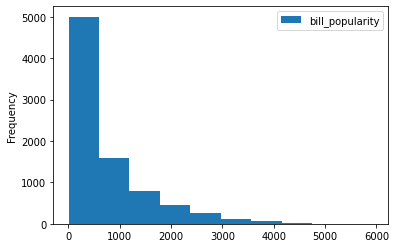

In [603]:
bill_with_tail.groupby("SongID").sum().reset_index().loc[:, ["SongID", "bill_popularity"]].sort_values("bill_popularity").plot(kind="hist", y="bill_popularity")

<AxesSubplot:ylabel='Frequency'>

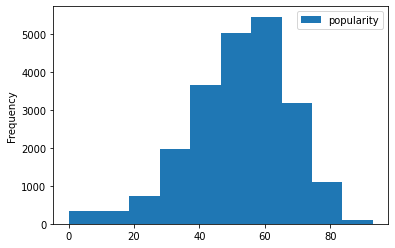

In [604]:
attributes.plot(kind="hist", y="popularity")

In [ ]:
# Need to find a way to transform bill_popularity to a normal [0, 100] Scale

In [632]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer 

In [622]:
Xs = bill_with_tail.groupby("SongID").sum().bill_popularity.values

In [623]:
pt = PowerTransformer("box-cox")

In [626]:
pt.fit(Xs.reshape(-1, 1))

PowerTransformer(copy=True, method='box-cox', standardize=True)

<AxesSubplot:ylabel='Frequency'>

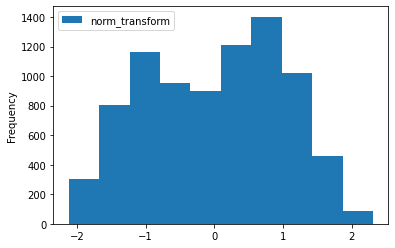

In [631]:
pd.DataFrame(pt.transform(Xs.reshape(-1, 1)).reshape(-1), columns=["norm_transform"]).plot(kind="hist", y="norm_transform")

In [633]:
qt = QuantileTransformer(output_distribution="normal")

In [634]:
qt.fit_transform(Xs.reshape(-1, 1))

array([[ 0.84069262],
       [ 0.6989583 ],
       [ 0.31392645],
       ...,
       [ 0.05146002],
       [-2.25674483],
       [-0.02383906]])

<AxesSubplot:ylabel='Frequency'>

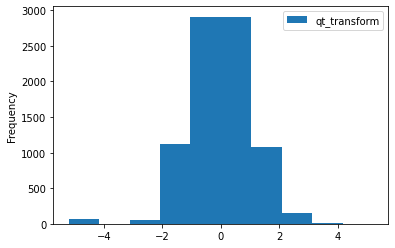

In [636]:
pd.DataFrame(qt.fit_transform(Xs.reshape(-1, 1)).reshape(-1), columns=["qt_transform"]).plot(kind="hist", y="qt_transform")

In [638]:
pt = PowerTransformer()

In [639]:
pt.fit(Xs.reshape(-1, 1))

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

<AxesSubplot:ylabel='Frequency'>

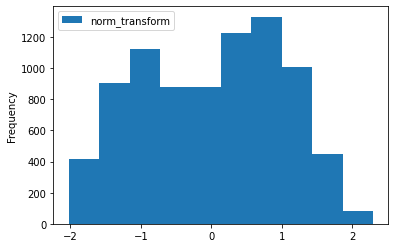

In [640]:
pd.DataFrame(pt.transform(Xs.reshape(-1, 1)).reshape(-1), columns=["norm_transform"]).plot(kind="hist", y="norm_transform")

In [651]:
chart_transforms= pd.DataFrame(data=zip(pt.transform(Xs.reshape(-1, 1)).reshape(-1).T, Xs), columns=["transform", "bill_popularity"]).sort_values("bill_popularity", ascending=False)

In [660]:
attributes.popularity.std()

15.532111033092209

In [656]:
chart_transforms[lambda x: x["transform"] > 0]

,transform,bill_popularity
5653,2.296479,5932
1310,2.245220,5625
3542,2.211960,5433
5404,2.197455,5351
6107,2.170616,5202
...,...,...
4907,0.000750,295
345,0.000750,295
7216,0.000750,295
6262,0.000750,295


In [657]:
chart_transforms[lambda x: x["transform"] < 0]

,transform,bill_popularity
3246,-0.001257,294
2922,-0.001257,294
2730,-0.001257,294
7613,-0.001257,294
3089,-0.003270,293
...,...,...
7478,-2.023836,1
1564,-2.023836,1
7514,-2.023836,1
7515,-2.023836,1


In [664]:
chart_transforms = chart_transforms.assign(scaled = lambda x: ((x["transform"]*attributes.popularity.std()) + attributes.popularity.mean()).apply(round, 0))

In [671]:
chart_transforms = chart_transforms.sort_index()

In [674]:
chart_transforms.loc[:, "SongID"] = bill_with_tail.groupby("SongID").sum().reset_index().SongID

In [685]:
bill_with_tail = bill_with_tail.sort_values(["tail", "WeekID", "Week Position"]).reset_index(drop=True)

In [688]:
chart_transforms = chart_transforms.rename(columns={"scaled": "scaled_popularity"})

In [690]:
attributes.merge(chart_transforms, "left", on="SongID")[lambda x: (x.chart == 1) & (np.isnan(x.bill_popularity))]

,Song,Performer,SongID,id,danceability,energy,key,loudness,mode,speechiness,...,explicit,popularity,release_date,chart,id_fk,genre,genre_super,transform,bill_popularity,scaled_popularity
21896,Damn Tana,LIL LO,damn tanalil lo,0BKlETtyw17Zz0d76Yfxs3,0.9,0.508,5.0,-8.161,0.0,0.336,...,1.0,26.0,2020-04-20,1.0,0BKlETtyw17Zz0d76Yfxs3,['dmv rap'],rap,NaN,NaN,NaN


In [702]:
bill_with_tail[lambda x: x.SongID.str.contains("lil")]

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,year,tail
1193,1999-03-20,94,anywhere,112 featuring lil'z,0.0,94.0,1.0,anywhere112 featuring lil'z,7,1.0,1999,0
1269,1999-03-27,70,anywhere,112 featuring lil'z,94.0,70.0,2.0,anywhere112 featuring lil'z,31,1.0,1999,0
1353,1999-04-03,54,anywhere,112 featuring lil'z,70.0,54.0,3.0,anywhere112 featuring lil'z,47,1.0,1999,0
1396,1999-04-03,97,with you,lila mccann,0.0,97.0,1.0,with youlila mccann,4,1.0,1999,0
1443,1999-04-10,44,anywhere,112 featuring lil'z,54.0,44.0,4.0,anywhere112 featuring lil'z,57,1.0,1999,0
...,...,...,...,...,...,...,...,...,...,...,...,...
111562,2020-03-21,48,futsal shuffle 2020,lil uzi vert,0.0,48.0,10.0,futsal shuffle 2020lil uzi vert,53,2.0,2020,1
111590,2020-03-28,28,woah,lil baby,31.0,15.0,19.0,woahlil baby,73,1.0,2020,1
111603,2020-03-28,94,futsal shuffle 2020,lil uzi vert,48.0,48.0,11.0,futsal shuffle 2020lil uzi vert,7,2.0,2020,1
111625,2020-04-04,42,woah,lil baby,28.0,15.0,20.0,woahlil baby,59,1.0,2020,1


In [703]:
attributes[lambda x: x.chart == 1].SongID.unique().shape

(8301,)

In [708]:
set(attributes[lambda x: x.chart == 1].SongID).difference(set(bill_with_tail.SongID))

{'damn tanalil lo'}

In [709]:
(set(bill_with_tail.SongID)).difference(set(attributes[lambda x: x.chart == 1].SongID))

{'hell of a lifet.i.', "i'm backt.i."}

In [714]:
bill_with_tail.merge(attributes.loc[:, ["Song", "SongID"]], "left", on="SongID")[lambda x: x.Song_y.isnull()]

,WeekID,Week Position,Song_x,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,year,tail,Song_y
56498,2009-10-24,54,hell of a life,t.i.,0.0,54.0,1.0,hell of a lifet.i.,47,1.0,2009,0,NaN
56637,2009-10-31,93,hell of a life,t.i.,54.0,54.0,2.0,hell of a lifet.i.,8,1.0,2009,0,NaN
58788,2010-04-03,44,i'm back,t.i.,0.0,44.0,1.0,i'm backt.i.,57,1.0,2010,0,NaN
58893,2010-04-10,49,i'm back,t.i.,44.0,44.0,2.0,i'm backt.i.,52,1.0,2010,0,NaN
59005,2010-04-17,61,i'm back,t.i.,49.0,44.0,3.0,i'm backt.i.,40,1.0,2010,0,NaN
59109,2010-04-24,65,i'm back,t.i.,61.0,44.0,4.0,i'm backt.i.,36,1.0,2010,0,NaN
59212,2010-05-01,68,i'm back,t.i.,65.0,44.0,5.0,i'm backt.i.,33,1.0,2010,0,NaN
59306,2010-05-08,62,i'm back,t.i.,68.0,44.0,6.0,i'm backt.i.,39,1.0,2010,0,NaN
59403,2010-05-15,59,i'm back,t.i.,62.0,44.0,7.0,i'm backt.i.,42,1.0,2010,0,NaN
59506,2010-05-22,62,i'm back,t.i.,59.0,44.0,8.0,i'm backt.i.,39,1.0,2010,0,NaN


In [730]:
attributes.loc[(lambda x: x.SongID.str.contains("damn tan")), "chart"] = 0

In [732]:
attributes[lambda x: x.SongID.str.contains("damn tan")]

,Song,Performer,SongID,id,danceability,energy,key,loudness,mode,speechiness,...,duration,id_y,explicit,popularity,release_date,chart,id_fk,genre,genre_super,"(<function <lambda> at 0x000002243A24ED90>, chart)"
21896,Damn Tana,LIL LO,damn tanalil lo,0BKlETtyw17Zz0d76Yfxs3,0.9,0.508,5.0,-8.161,0.0,0.336,...,121856.0,0BKlETtyw17Zz0d76Yfxs3,1.0,26.0,2020-04-20,0.0,0BKlETtyw17Zz0d76Yfxs3,['dmv rap'],rap,0


In [742]:
attributes = attributes.iloc[:, :-1]

In [743]:
set(attributes[lambda x: x.chart == 1].SongID).difference(set(bill_with_tail.SongID))

set()

In [744]:
(set(bill_with_tail.SongID)).difference(set(attributes[lambda x: x.chart == 1].SongID))

{'hell of a lifet.i.', "i'm backt.i."}

In [745]:
bill_with_tail.merge(attributes.loc[:,["SongID", "energy"]], "left", on=["SongID"])[lambda x: x.energy.isnull()]

,WeekID,Week Position,Song,Performer,Previous Week Position,Peak Position,Weeks on Chart,SongID,bill_popularity,Instance,year,tail,energy
898,1999-02-27,99,if you could read my mind,"stars on 54: ultra nate, amber, jocelyn enriquez",0.0,99.0,15.0,if you could read my mindstars on 54: ultra na...,2,2.0,1999,0,NaN
10395,2000-12-23,96,all good?,de la soul featuring chaka khan,0.0,96.0,1.0,all good?de la soul featuring chaka khan,5,1.0,2000,0,NaN
10495,2000-12-30,96,all good?,de la soul featuring chaka khan,96.0,96.0,2.0,all good?de la soul featuring chaka khan,5,1.0,2000,0,NaN
10599,2001-01-06,100,all good?,de la soul featuring chaka khan,96.0,96.0,3.0,all good?de la soul featuring chaka khan,1,1.0,2001,0,NaN
23198,2003-06-07,99,make me a song,kiley dean,0.0,99.0,1.0,make me a songkiley dean,2,1.0,2003,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110420,1998-10-31,57,if you could read my mind,"stars on 54: ultra nate, amber, jocelyn enriquez",62.0,57.0,10.0,if you could read my mindstars on 54: ultra na...,44,1.0,1998,1,NaN
110451,1998-11-07,64,if you could read my mind,"stars on 54: ultra nate, amber, jocelyn enriquez",57.0,57.0,11.0,if you could read my mindstars on 54: ultra na...,37,1.0,1998,1,NaN
110485,1998-11-14,66,if you could read my mind,"stars on 54: ultra nate, amber, jocelyn enriquez",64.0,57.0,12.0,if you could read my mindstars on 54: ultra na...,35,1.0,1998,1,NaN
110520,1998-11-21,56,if you could read my mind,"stars on 54: ultra nate, amber, jocelyn enriquez",66.0,56.0,13.0,if you could read my mindstars on 54: ultra na...,45,1.0,1998,1,NaN


In [748]:
add_to_attr = (set(bill_with_tail.SongID)).difference(set(attributes[lambda x: x.chart == 1].SongID))

In [751]:
to_attr_df = bill_with_tail[lambda x: x.SongID.isin(add_to_attr)].drop_duplicates(subset=["SongID"]).loc[:, ["Song", "Performer", "SongID"]]

In [752]:
to_attr_df.loc[:, "chart"] = 1
to_attr_df.loc[:, "genre_super"] = "rap"

In [758]:
to_attr_df.loc[:, ["id", "id_y", "genre", "id_fk"]] = None

In [759]:
to_attr_df.loc[:, ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'timesignature', 'duration',
       'explicit', 'popularity']] = np.nan

In [768]:
to_attr_df.loc[:, ["release_date"]] = None

In [769]:
attributes.columns

Index(['Song', 'Performer', 'SongID', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'timesignature', 'duration', 'id_y',
       'explicit', 'popularity', 'release_date', 'chart', 'id_fk', 'genre',
       'genre_super'],
      dtype='object')

In [771]:
to_attr_df = to_attr_df.loc[:, ['Song', 'Performer', 'SongID', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'timesignature', 'duration', 'id_y',
       'explicit', 'popularity', 'release_date', 'chart', 'id_fk', 'genre',
       'genre_super']]

In [774]:
update_attributes =pd.concat([attributes, to_attr_df], ignore_index=True, axis=0)

In [776]:
update_attributes = update_attributes.merge(chart_transforms, "left", on="SongID")

In [783]:
with engine.connect() as con:
    bill_with_tail.to_sql("billboard", con=con, index=False, if_exists="replace")
    update_attributes.to_sql("attributes", con=con, index=False, if_exists="replace")